<a href="https://colab.research.google.com/github/physicsllama/rl-quantum/blob/main/Q-Learning%20Bloch's%20Theorem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install -q qutip

In [191]:
import numpy as np
import cmath
import random
import matplotlib.pyplot as plt
from gym import Env
from gym.spaces import Discrete, Box, Dict
from qutip import *

# Qubit environment

In [420]:
qubit_eps = 0.01

# Defining parts of the environment to deal with "continuous" variables (angles)
samples = 30
theta = np.linspace(0, np.pi, samples)
phi = np.linspace(0, 2*np.pi, samples)

# Fixed initial and final angles. Use theta1 only for initial testing.
theta1 = random.choice(theta)
phi1 = random.choice(phi)
theta2 = random.choice(theta)
phi2 = random.choice(phi)

final_qubit = np.array([np.cos(theta2 / 2), np.exp(1j * phi2) * np.sin(theta2 / 2)])

class QubitUnitary(Env):
    def __init__(self):
        # What we can observe: a single qubit, # characterized by 2 real angles on the Bloch sphere.
        self.observation_space = Box(low=np.array([0, 0]), 
                                     high=np.array([np.pi, 2*np.pi]), shape=(2,))
        
        # What actions we can take: choose a unitary along an axis (y or z) 
        # and a real angle of rotation around that axis.
        self.action_space = Dict({"axis": Discrete(2),
                                  "angle": Box(low=0, high=2*np.pi, shape=(1,))})
        
        #Starting qubit. Can be the same every time, or different every time.
        self.theta = theta1
        self.phi = phi1
        self.state = np.array([self.theta, self.phi])
        self.qubit = np.array([np.cos(self.theta/2), np.exp(1j*self.phi)*np.sin(self.theta/2)])
        
        # Maximum number of unitaries before resetting
        self.max_unitaries = 10

        # Visualization
        self.b = Bloch()
    
    def rot(self, axis, angle):
        # If axis = 0, rotate y. if axis = 1, rotate z. Return the unitary for rotation along correct axis and angle.
        if axis == 0:
          return np.array([[np.cos(angle / 2), -np.sin(angle / 2)], [np.sin(angle / 2), np.cos(angle / 2)]])
        elif axis == 1:
          return np.array([[np.exp(-1j * angle / 2), 0], [0, np.exp(1j * angle / 2)]])
        else:
          return None

    def qubit_fidelity(self, qubit1, qubit2):
      return np.dot(qubit1, np.conjugate(qubit2)) * np.dot(np.conjugate(qubit1),qubit2)

    def step(self, action):
        # Update the qubit depending on what action we took
        self.qubit = np.dot(self.rot(action["axis"], action["angle"][0]), self.qubit)

        # Update parameters and state
        self.theta = 2 * np.arccos(np.abs(self.qubit[0])-0.0001)
        self.phi = (cmath.phase(self.qubit[1]) - cmath.phase(self.qubit[0]))%(2*np.pi)
        self.state = [self.theta, self.phi]

        # Decrease unitaries remaining
        self.max_unitaries -= 1

        # Reward step. Use criterion of distance to final qubit. This part can be experimented with.
        if self.qubit_fidelity(self.qubit, final_qubit) > (1 - qubit_eps):
            reward = 10
        else:
            reward = -1
            
        # Check if we've used up all unitaries:
        if self.qubit_fidelity(self.qubit,final_qubit)>(1-qubit_eps) or self.max_unitaries<=0:
            done = True
        else:
            done = False
        # Maybe use info for rendering!
        info = {}

        return self.state, reward, done, info

    def render(self):
        self.b = Bloch()
        self.b.vector_color = ['r']
        self.b.view = [-40,30]

    def reset(self):
        # Reset qubit to initial state.
        self.theta = random.choice(theta)
        self.phi = random.choice(phi)
        #self.theta = theta1
        #self.phi = phi1
        self.state = np.array([self.theta, self.phi])
        self.qubit = np.array([np.cos(self.theta/2), np.exp(1j*self.phi)*np.sin(self.theta/2)])

        # Reset max number of unitaries
        self.max_unitaries = 10

In [421]:
env = QubitUnitary()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# RL Algorithm for Q-Learning

In [422]:
# Q_Fit is needed if we use fitted Q-learning.
Q_Fit = np.zeros((samples**3 * 2,1))

# Q_Matrix is organized as [theta, phi, angle, axis].
Q_Matrix = np.reshape(Q_Fit, (samples,samples,samples,2,1))

In [423]:
# Use epsilon-greedy strategy to explore space of possibilities and update Q values.
def select_action(s, epsilon):
  p = random.random()
  if p < epsilon:
    return env.action_space.sample()
  else:
    # Indices associated to s1, s2.
    s1 = int( np.floor((samples-1)*s[0]/np.pi))
    s2 = int( np.floor((samples-1)*s[1]/(2.0*np.pi)))
    # Best index from argmax of q.
    best_index = np.unravel_index(Q_Matrix[s1][s2].argmax(), Q_Matrix[s1][s2].shape)
    best_angle = phi[best_index[0]]
    best_axis = best_index[1]
    best_action = {'axis': best_axis, 'angle': [best_angle]}
    return best_action

In [409]:
# Update Q step.
def update_Q(s, a, alpha, gamma):
  # Indices corresponding to s, a.
  s1 = int( np.floor((samples-1)*s[0]/np.pi))
  s2 = int( np.floor((samples-1)*s[1]/(2.0*np.pi)))
  a1 = int( np.floor((samples-1)*a['angle'][0]/(2.0*np.pi)))
  a2 = a['axis']
  # Take step, find new indices.
  new_s, reward, done, info = env.step(a)
  new_s1 = int( np.floor((samples-1)*new_s[0]/np.pi)) 
  new_s2 = int( np.floor((samples-1)*new_s[1]/(2.0*np.pi))) 
  old_Q = Q_Matrix[s1][s2][a1][a2]
  Q_Matrix[s1][s2][a1][a2]=(1-alpha)*old_Q+alpha*(reward+gamma*np.max(Q_Matrix[new_s1][new_s2]))
  return done

# Training

In [410]:
num_attempts = []

In [411]:
# Full exploration phase: only attempt random unitaries.
warmup_steps = 50000

# Run epochs of training with just exploration, and low discount rate.
while warmup_steps > 0:
  env.reset()

  # Run loop where we get to explore until done (10 unitaries, or reach goal).
  Done = False

  while not Done:
    s = env.state
    action = env.action_space.sample()
    Done = update_Q(s, action, 0.99, 0.1)

    if warmup_steps%10 == 0:
      env.reset()
      count = 0
      Done_data = False
      while not Done_data:
        count += 1
        s = env.state
        action = select_action(s, 0)
        Done_data = update_Q(s, action, 0.99, 0.1)
      num_attempts.append(count)
  
  warmup_steps -= 1

In [412]:
# More exploitation: slowly lower epsilon.
runs = 10
eps = 0.7
alpha = 0.99
while runs >= 0:

  epochs = 50000
  while epochs >= 0:
    env.reset()
    # Run loop where we get to explore until done (10 unitaries, or reach goal).
    Done = False
    while not Done:
      s = env.state
      action = select_action(s, eps)
      Done = update_Q(s, action, alpha, 0.1)

    # Uncomment part below if you want to acquire data.
    if epochs%10 == 0:
      env.reset()
      count = 0
      Done_data = False
      while not Done_data:
        count += 1
        s = env.state
        action = select_action(s, 0)
        Done_data = update_Q(s, action, alpha, 0.1)
      num_attempts.append(count)

    epochs -= 1

  #alpha -= 0.001
  eps -= 0.1
  runs -= 1

# Results

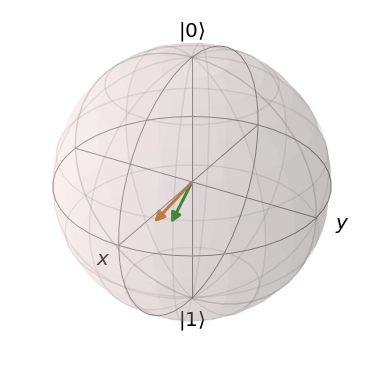

0.999000999000999


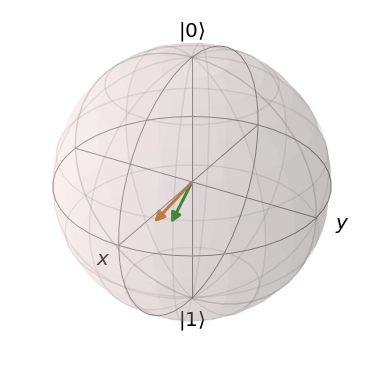

In [418]:
total = 1000
numb_needed = []


b = Bloch()
b.clear()
current = [np.sin(env.theta)*np.cos(env.phi), np.sin(env.theta)*np.sin(env.phi), np.cos(env.theta)]
final = [np.sin(theta2)*np.cos(phi2), np.sin(theta2)*np.sin(phi2), np.cos(theta2)]
vec = [current, final]
b.add_vectors(vec)
b.show()


while total >= 0:
  env.reset()

  Done = False
  counter = 0
 
  while not Done:
    counter += 1
    s = env.state
    #print(env.qubit)
    action = select_action(s, 0)
    st, r, Done, info = env.step(action)
    #print(env.qubit)
    #print(action)

  total -= 1

  numb_needed.append(counter)

success = 0
for i in numb_needed:
  if i <=2:
    success += 1

print(success / len(numb_needed))

In [ ]:
# Some messy things I used for plotting are below.

In [293]:
'''num_averaged = np.zeros(int((len(num_attempts)-71)/100))

for i in range(len(num_attempts)-71):
  if (i+1)%10==0:
    for j in range(10):
      index = int((i+1)/100-1)
      #print(index)
      newindex = i+j
      num_averaged[index] += num_attempts[newindex]

weighted = num_averaged / 100
data_final = list(weighted)
data_final.pop()'''

In [ ]:
'''
plt.plot(data_final)
plt.xlabel('log((Number of epochs) / 100)')
plt.ylabel('Average number of gates needed')
plt.title('Improvements from training (log scale)')
plt.xscale('log')
plt.savefig('Traininglog')
'''

In [ ]:
'''
gamma_statistics: required 99% fidelity
for 0
for 0.01 99.9 
for 0.1, 99.7% success
for 0.2, 100%
for 0.3, we had 99.6% 
for 0.4, 97.9
for 0.5, 98.7
for 0.6, 99.8
for 0.7, 99.8
for 0.8, 99.9
for 0.9, 100
for 0.99 96.5

'''